In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, root_mean_squared_error


url = 'https://raw.githubusercontent.com/arjayit/cs4432_data/master/bike_share_hour.csv'
df = pd.read_csv(url)
df = df.drop(columns=['dteday', 'instant'])
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Part 1: Data Exploration
Dataset characteristics

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 2.0 MB


In [43]:
# convert categorical cols
cat_cols = ['season', 'yr', 'hr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

for col in cat_cols:
    df[col] = df[col].astype('category')

In [44]:
# check for nulls
df.isna().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [45]:
# which months belong to what seasons?
df[['mnth', 'season']].drop_duplicates()

,mnth,season
0,1,1
688,2,1
1337,3,1
1807,3,2
2067,4,2
2786,5,2
3530,6,2
4010,6,3
4250,7,3
4994,8,3


Based on the code above and the readme, the assignment of months to season in the bike share dataset description seems to have a typo. It sets the winter months as spring, the spring as summer, summer as fall, and fall as winter months. 

Therefore the actual season : [months] should be

- Winter Months (1): Dec, Jan, Feb, Mar
- Spring Months (2): Mar, Apr, May, Jun
- Summer Months (3): Jun, Jul, Aug, Sep
- Fall Months (4): Sep, Oct, Nov, Dec

In [46]:
df.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


The ranges of temp, atemp, and hum are from 0 to 1. This strongly suggests that these columns have already been scaled (normalized).

Windspeed, casual, registered, and count however are their true values. 

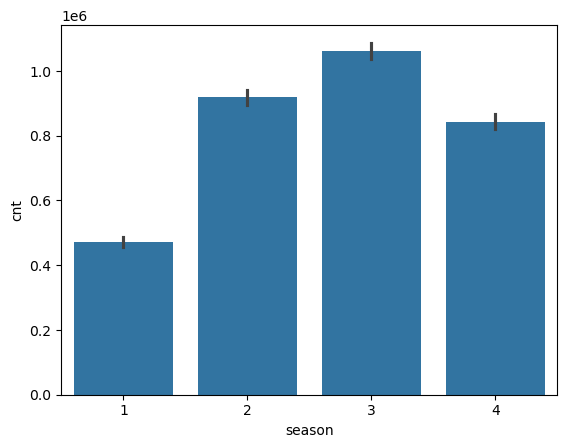

In [47]:
# Construct a bar plot of cnt versus season.  
# In a Markdown cell, document any pattern observed.  Does this agree with your intuition?

sns.barplot(x=df['season'], y=df['cnt'], estimator=np.sum);

ANS: We see the lowest count in the winter season, which then increase into spring, maximizes during the summer, and then drops slightly down in the fall. This pattern is expected given that summer is usually when most people are out and about and active.

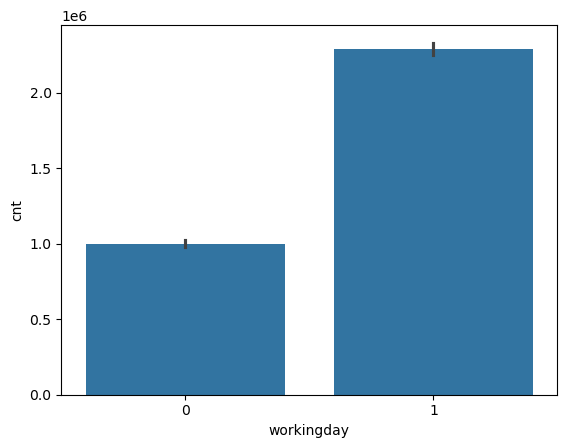

In [48]:
# Construct a bar chart of cnt versus workingday  
# In Markdown cell, document how bike rides are distributed across the two options of working day.  
# Consider whether the sum or the mean is a better representation.

sns.barplot(x=df['workingday'], y=df['cnt'], estimator=np.sum);

ANS: On first pass, it looks like the bike share counts working days are much higher than non-working days. However, there are way more working days than non-working days in a year and will misrepresent the comparison. In this case, the total count or sum is not the best representation of this data. Therefore, the mean would be a better representation.

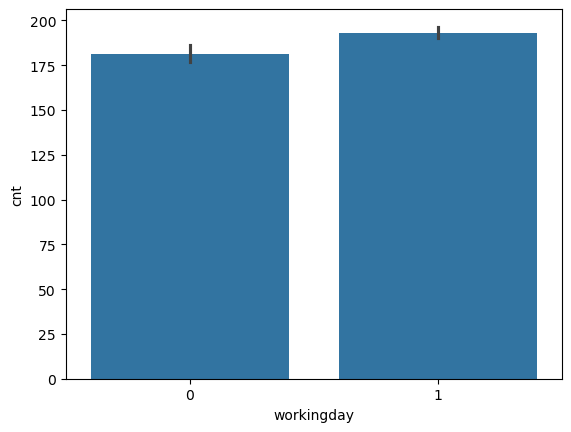

In [49]:
# looking at the mean, we can see that the two values are much closer (tho working days is still higher)
sns.barplot(x=df['workingday'], y=df['cnt'],estimator=np.mean);

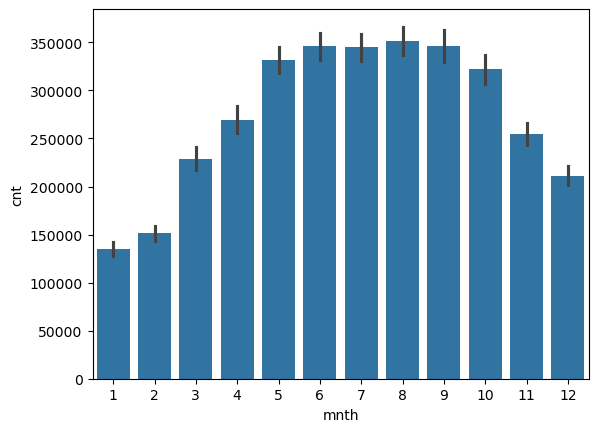

In [50]:
# Construct a bar chart for cnt versus mnth.  
# In a Markdown cell, discuss the pattern.  Does this agree with your intuition?

sns.barplot(x=df['mnth'], y=df['cnt'], estimator=np.sum);

ANS: Similar to the pattern we saw for season, we see the lowest bike share activity count in the colder months from January-March, then it picks up in the Spring (March-May), maxes out in the hottest months (June-Sep), and then starts to decrease as the weather cools in the fall. This is expected as the hot, dry months in North America are when most people are active and outside.

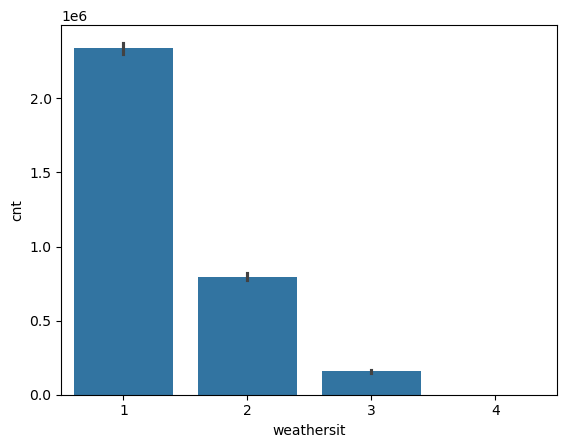

In [51]:
# Construct a bar plot of cnt versus weathersit.   
# In a Markdown cell,  discuss the pattern.

sns.barplot(x=df['weathersit'], y=df['cnt'], estimator=np.sum);

- weathersit
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

ANS: Weather situation values go from best weather (1) to worst weather (4). The pattern we see is heavy right skew where most bike share activity occurs in the best weather and quickly drops off as weather worsens.

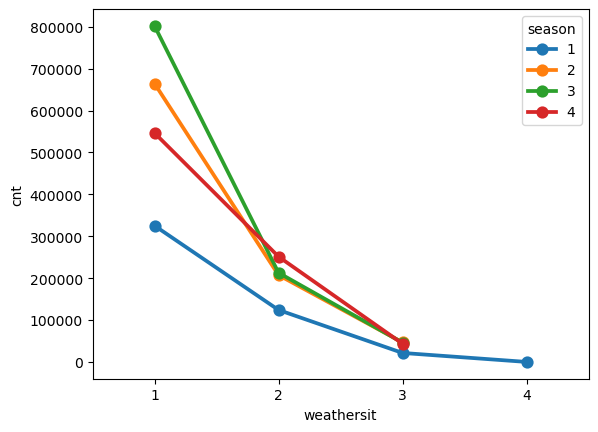

In [52]:
# Construct a point plot of weathersit on the x-axis, cnt on the y-axis, and season as the hue.  
# In a Markdown cell, document how season and weathersit are related. 

sns.pointplot(x='weathersit', y='cnt', estimator=np.sum, hue='season', data=df, errorbar=None);

ANS:
- Season 1 (Winter): winter looks to have the lowest count of "great weather" and the highest amount of non-good weather
- Season 3 (Summer): summer looks to have the highest count of "great weather" and the lowest amount of non-good weather

Overall, the seasons and weather situations follow a pattern and are correlated to one another. The good weather associated with weather situation 1/2 is most aligned with what you would find in Spring/Summer and the bad weather you would find in 3/4 is most aligned with Fall/Winter.

The same relationship exists where better weather is directly proportional to more rides.

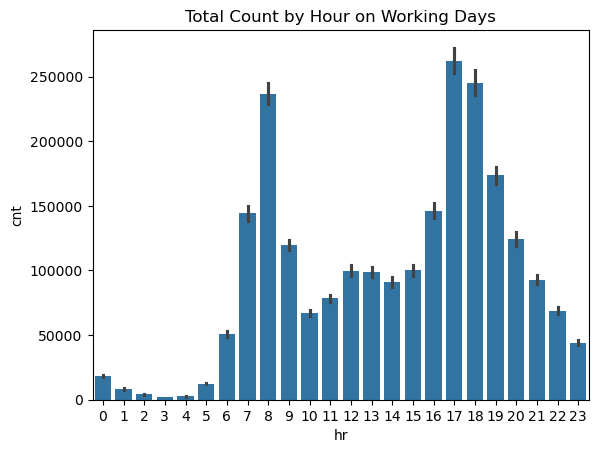

In [53]:
# Construct a bar plot of cnt versus hr for workingday = 1.  
# In a Markdown cell, discuss the pattern?  Does this agree with your intuition?

# filter df to be for workingday == 1
df_workingday = df.loc[df['workingday'] == 1]

sns.barplot(x=df_workingday['hr'], y=df_workingday['cnt'], estimator=np.sum)

plt.title('Total Count by Hour on Working Days')

plt.show()

ANS: The pattern looks to be very low activity in the late night/early morning, a spike between 7-10a, then low-to-moderate activity during business hours, and then another spike between 4-8p. This follows my intution as the bike share activity looks to be correlated with commuting times on working days. There's a spike during the morning and afternoon commuting rush (as expected).

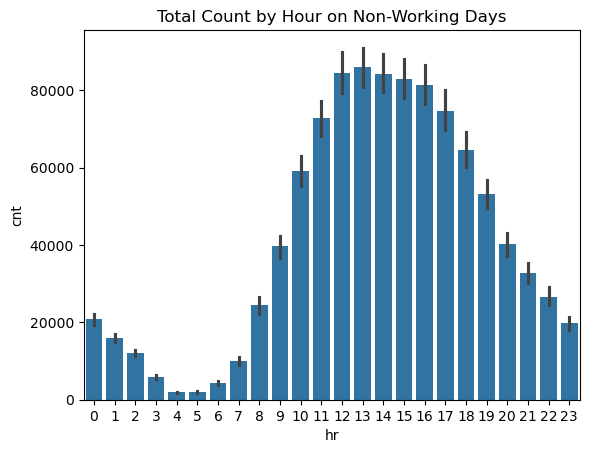

In [54]:
# Construct a bar plot of cnt versus hr for workingday = 0. 
# In a Markdown cell, discuss the pattern, and how it compares to workingday = 1.

# filter df to be for workingday == 0
df_non_workday = df.loc[df['workingday'] == 0]

sns.barplot(x=df_non_workday['hr'], y=df_non_workday['cnt'], estimator=np.sum)

plt.title('Total Count by Hour on Non-Working Days')

plt.show()

ANS: The pattern of the data here is for non-worky days (weekends/holidays). There is useage in the late evening/eary morning, low useage from around 4-6a, and then an increase of usage at around 9am and then maximum/bell-shaped curve between 12-4p. The usage then gradually decreases in the night. This follows my intuition of how bike shares get used on recreational days. The super early morning rides I imagine are from people out late at night who had a few drinks and are getting home safely ;). The rest of the activity for the rest of the day is almost normal around the main hours of the day which is from 10-3p when most people are out and about, enjoying the outsude, and where most businesses are open. 

This is in contrast to the working days where most of the activity is spiking during commuting hours and then activity lessens during core business hours when people are working. The two distributions are almost inverse to one another which again, is expected.

In [55]:
df['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

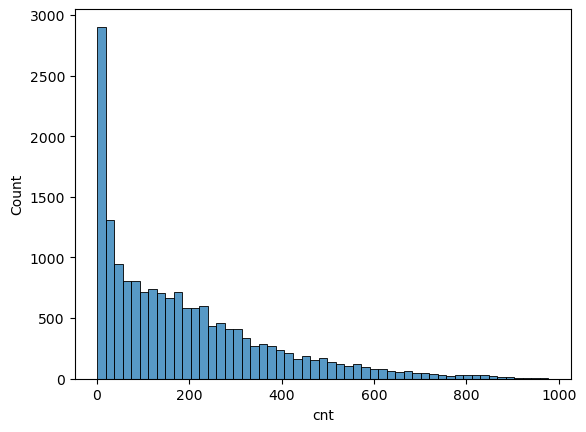

In [56]:
# Construct a histogram of the cnt column.  
# In a Markdown cell, what can be said based on the resulting distribution?

sns.histplot(df['cnt']);

ANS: The resulting distribution is highly right skewed with a long right tail for hourly bike rentals. The value cnts gives the total number of bikes being rented out in a specific hour of a specific day. Therefore, we can see that the majority of the time, for a specific hour, that the amount of bikes on the road is less than one hundred. As the count of bikes/hour goes up, the amount of those instances drastically decresaes. The long right tail also suggests occasional periods of very high demand which as we saw above, which can possibly be from rush hours or special events/holidays.

In addition, the wide range of rental counts from 1 to nearly 1000 indicates high variability in usage. This variability can come from all sorts of factors like we explored earlier. This can be seen in time of day, day of the week, weather conditions, and seasonal effects. 

# Part 2: Data Preparation

In [57]:
df.corr(numeric_only=True)

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,0.093234
casual,0.459616,0.454080,-0.347028,0.090287,1.000000,0.506618,0.694564
registered,0.335361,0.332559,-0.273933,0.082321,0.506618,1.000000,0.972151
cnt,0.404772,0.400929,-0.322911,0.093234,0.694564,0.972151,1.000000


The most highly correlated values look to be:
- atemp and temp
- registered and cnt
- casual and cnt

In [58]:
# drop cols
df = df.drop(columns=['casual', 'registered', 'atemp'])

In [59]:
# train test split

# Separate features and target
X = df.drop(columns=['cnt'])
y = df['cnt']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=432)

# Part 3: Baseline Model Construction
Construct a baseline linear regression model using either cross_val_score or cross_validate methods 
from sklearn.model_selection, and the following: 
- Linear Regressor estimator (sklearn.linear_model.LinearRegression) 
- Training data from Part 2C  
- r2_score and neg_root_mean_squared_error evaluation metrics 
- Five folds 


Print the average R-Squared and average RMSE values over the 5 folds.


Note: The scores obtained demonstrate the performance of a linear regressor without introducing 
dummy variables for the categorical features.

In [60]:
def evaluate_regressor(regressor: Pipeline, X: pd.DataFrame, y: pd.Series, cv: int = 5):
    """
    Prints out the average R-squared/RMSE of a given regressor. 
    Args:
        regressor: regressor that's based off an Sklearn pipeline
        X: dataframe with input features
        y: series with target variable
        cv: number of folds for cross-validation
    Results:
        tuple : avg_r2, avg_rmse
    """
    # scoring metrics
    scoring = {
        'r2': 'r2',
        'neg_rmse': 'neg_root_mean_squared_error'
    }

    # cross-validation w/ 5 folds
    cv_results = cross_validate(
        regressor, 
        X, 
        y, 
        cv=cv, 
        scoring=scoring
    )

    # get the avg R-Squared and RMSE
    avg_r2 = cv_results['test_r2'].mean()
    avg_rmse = -cv_results['test_neg_rmse'].mean() 

    print(f"Average R-Squared: {avg_r2:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")

    return avg_r2, avg_rmse

In [61]:
# pipeline
lr_pipe_base = Pipeline([
    ('linear_regressor', LinearRegression())
])

# print out the avg r-squared and RMSE
lr_base_avg_r2, lr_base_avg_rmse = evaluate_regressor(lr_pipe_base, X_train, y_train)

Average R-Squared: 0.3889
Average RMSE: 141.6630


# Part 4: Initial Model Training
One-hot encode feature set to train:
- Linear Regressor
- Deciscion Tree Regressor
- Random Forest Regressor

In [62]:
# one-hot encode categorical cols first
X = pd.get_dummies(df, drop_first=True, dtype=int).drop(columns=['cnt'])
y = df['cnt']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=432)

In [63]:
# create the Linear Regressor with One-Hot Encoding
lr_pipe_final = Pipeline([
    ('linear_regressor', LinearRegression())
])

# print out the avg r-squared and RMSE
lr_avg_r2, lr_avg_rmse = evaluate_regressor(lr_pipe_final, X_train, y_train)

Average R-Squared: 0.6806
Average RMSE: 102.3949


Comparing the average R-squared and average RMSE between the one-hot encoded and non one-hot encoded feature set, we can see that the linear regressor improved substantially in the one-hot encoded training set. 
- Avg R-squared improved from 0.389 to 0.681 indicating an improvement in the "goodness of fit" of the linear model
  - this statistic shows the proportion of variance in the predicted target that can be explained by the features
- Avg RMSE decreased from 141.7 to 102.4 indicating an improvement in the accuracy of the predictions

Overall, the introduction of dummy variables to the training set improved the performance of the linear regressor.

In [64]:
# create the Deciscion Tree Regressor with One-Hot Encoding
dtr_pipe_final = Pipeline([
    ('decision_tree_regressor', DecisionTreeRegressor(random_state=0))
])

# print out the avg r-squared and RMSE
dtr_avg_r2, dtr_avg_rmse = evaluate_regressor(dtr_pipe_final, X_train, y_train)

Average R-Squared: 0.8043
Average RMSE: 80.1114


In [65]:
# create the Random Forest Regressor with One-Hot Encoding
rfr_pipe_final = Pipeline([
    ('random_forest_regressor', RandomForestRegressor(random_state=0))
])

# print out the avg r-squared and RMSE
rfr_avg_r2, rfr_avg_rmse = evaluate_regressor(rfr_pipe_final, X_train, y_train)

Average R-Squared: 0.8994
Average RMSE: 57.4745


Present a table that shows the average R-Squared and average RMSE values for the three algorithms 
used in Parts 4C-4F.  
- These metrics reflect the performance of the algorithms with default 
hyperparameter settings.

In [66]:
models_names = ['linear_regressor', 'decision_tree_regressor', 'random_forest_regressor']
avg_r2s = [lr_avg_r2, dtr_avg_r2, rfr_avg_r2]
avg_rmses = [lr_avg_rmse, dtr_avg_rmse, rfr_avg_rmse]

df_scores = pd.DataFrame({
    'model':models_names,
    'avg_r2': avg_r2s,
    'avg_rmse': avg_rmses
})

df_scores

,model,avg_r2,avg_rmse
0,linear_regressor,0.680627,102.394908
1,decision_tree_regressor,0.804281,80.111438
2,random_forest_regressor,0.899385,57.474476


# Part 5: Model Tuning
- Random search on Random Forest Regressor using One-hot Encoded Featureset

In [67]:
# search space
param_dist = {
    'random_forest_regressor__max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'random_forest_regressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'random_forest_regressor__n_estimators': [50, 100, 150, 200, 250]
}

# radom search params based on assignment
random_search = RandomizedSearchCV(
    estimator=rfr_pipe_final,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=0,
    n_jobs=-1  # Use all available cores
)

# fit 
random_search.fit(X_train, y_train)

# optimal hyperparameters
print("Best parameters:", random_search.best_params_)


Best parameters: {'random_forest_regressor__n_estimators': 200, 'random_forest_regressor__max_features': 1.0, 'random_forest_regressor__max_depth': 35}


In [68]:
rfr_random_search_r2, rfr_random_search_rmse = evaluate_regressor(random_search.best_estimator_, X_train, y_train)

Average R-Squared: 0.8999
Average RMSE: 57.3219


In [69]:
# default RF Regressor versus random search RF Regressor
models_names = ['rf_regressor', 'rf_regressor_rand_search']
avg_r2s = [rfr_avg_r2, rfr_random_search_r2]
avg_rmses = [rfr_avg_rmse, rfr_random_search_rmse]

pd.DataFrame({
    'model':models_names,
    'avg_r2': avg_r2s,
    'avg_rmse': avg_rmses
})

,model,avg_r2,avg_rmse
0,rf_regressor,0.899385,57.474476
1,rf_regressor_rand_search,0.899910,57.321914


Looking at the evaluation scores of the Random Forest Regressor with base params and the Random Forest Regressor with optimized params via Random Search Cross Validation, we can see that the random search led to marginally better results with VERY slight increase in average R-squared and a similarly small decrease in average RMSE. This improvement can potentially be explained in that the Random Search gave a bigger set of hyperparameters to test out. While it is not guranteed, in this case, we were able to find a combination outside the default parameters that do indeed improve the performance of the model.

In [70]:
# Final Eval on tuned Random Forest Regressor on dummied testing data
# get predictions for y_test
y_pred = random_search.predict(X_test)

# get scores
rfr_final_r2 = r2_score(y_test, y_pred)
rfr_final_rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {rfr_final_r2:.4f}")
print(f"RMSE: {rfr_final_rmse:.4f}")

R-squared: 0.9073
RMSE: 55.2868


How do the R-Squared Score and RMSE score compare to the scores found in Part 4G?

In [71]:
# score from part 4G
df_scores

,model,avg_r2,avg_rmse
0,linear_regressor,0.680627,102.394908
1,decision_tree_regressor,0.804281,80.111438
2,random_forest_regressor,0.899385,57.474476


In [72]:
# final model comparison table
models_names = ['random_forest_regressor_final']
final_r2 = [rfr_final_r2]
final_rmse = [rfr_final_rmse]

df_score_final = pd.DataFrame({
    'model':models_names,
    'final_r2': final_r2,
    'final_rmse': final_rmse
})

df_score_final

,model,final_r2,final_rmse
0,random_forest_regressor_final,0.90726,55.286831


### Final Comparison

__Note:__ 
- The first three models from part 4G (`df_scores`) are all evaluated on y_train with 5-fold cross validation. They represent the average metrics over 5 folds.
- The final evaluation was on the test data, y_yest (`df_score_final`) and represents the final test R-squared/RMSE value for the final random forest regressor.

Based on the results from 4G and the final test evaluation on the model tuned in part 5A, we see that the tuned RandomForestRegressor predicting on the dummied testing data sets has the best perforamnce out of all the models. 

The final R-squared value is 0.91 (a 0.1 point improvement from the best performing random forest model) and has a final RMSE of 55.3 (a 2.2 point improvement over the best random forest model).  

Therefore, the final random forest regressor tuned via random search and one-hot encoded is the best candidate for predicting counts of bikes being used in the bike share system for a given hour in a given day. This example ML model training shows the importance of not only choosing the best performing base model, but also feature engineering (scaling/one-hot encoding/etc), and hyperparameter tuning. Not doing the last items effectively leaves a lot of performance gains on the table that could not be realized otherwise (unless you get more or better data!).